In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import time
import json
from tqdm import tqdm
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet50_Weights

In [2]:
# Params
training_date = time.strftime("%Y%m%d-%H%M%S")
BACTH_SIZE = 64
MODEL_NAME = f'MDM_IaA_fulldata_{training_date}'
DATASET_FILE_PATH = 'C:/Users/janny/Aalto_project_2/data/full_dataset_IaA.txt'
MODEL_DIR = os.path.join("C:/Users/janny/Aalto_project_2/models", MODEL_NAME)

In [3]:
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.annotations = pd.read_csv(annotations_file, sep=', ', header=None)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_paths = row[:5].values  # Paths to the image files
        spectrogram_paths = row[5:12].values  # Paths to the audio spectrogram files
        label = row[12]
        
        # Load images and spectrograms, apply the same transform if available
        images = [read_image(path) for path in img_paths]
        spectrograms = [read_image(path) for path in spectrogram_paths]
        
        # Apply transforms to images and spectrograms if specified
        if self.transform:
            images = [self.transform(image) for image in images]
            spectrograms = [self.transform(spectrogram) for spectrogram in spectrograms]

        # Transform label if a target transform is specified
        if self.target_transform:
            label = self.target_transform(label)

        # Example: return the first image and spectrogram along with the label
        # You might want to adjust this depending on how your model expects the input
        return images, spectrograms, label

In [6]:
class ResizeToWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, img_tensor):
        # Make sure it's a float for division to work properly in Python 2
        original_width = img_tensor.shape[2]
        original_height = img_tensor.shape[1]
        aspect_ratio = float(original_height) / float(original_width)
        target_height = int(self.target_width * aspect_ratio)

        # Resize the tensor
        img_tensor = F.resize(img_tensor, [target_height, self.target_width])
        return img_tensor
    
class Normalize3Channel:
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, img_tensor):
        # Check if the image has 3 channels
        img_tensor = img_tensor.float() / 255.0
        if img_tensor.shape[0] == 3:
            img_tensor = F.normalize(img_tensor, mean=self.mean, std=self.std)
        return img_tensor


In [7]:
transform = transforms.Compose([
    ResizeToWidth(512),  # Resize width to 512 pixels while maintaining aspect ratio
    Normalize3Channel(),
])

dataset = CustomDataset(
    annotations_file=DATASET_FILE_PATH,
    transform=transform,
    # Optionally, apply a transform to the labels if necessary
)

C:\Users\janny\AppData\Local\Temp\ipykernel_29908\2510039581.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.annotations = pd.read_csv(annotations_file, sep=', ', header=None)


In [8]:
generator = torch.Generator().manual_seed(42)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Randomly split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BACTH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BACTH_SIZE, shuffle=False)

In [9]:
def visualize_tensor(tensor):
    # Assuming tensor shape is [1, 3, H, W], we select the first item in the batch
    # and convert it to a NumPy array after normalizing
    tensor = tensor[0]  # Select the first item in the batch
    # Convert from tensor to PIL Image to easily display it
    image = F.to_pil_image(tensor)
    plt.imshow(image)
    plt.axis('off')  # Hide axes ticks
    plt.show()

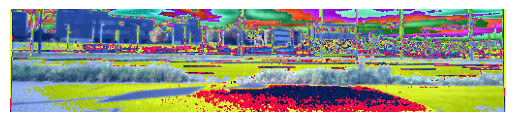

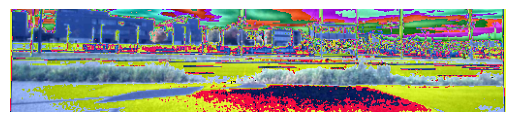

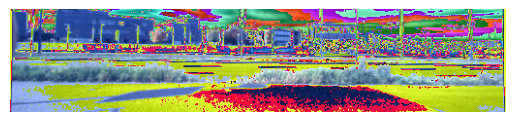

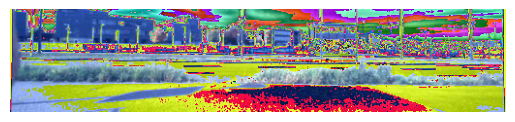

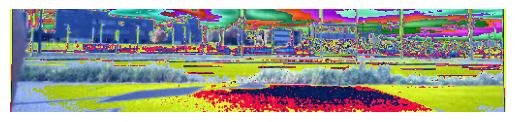

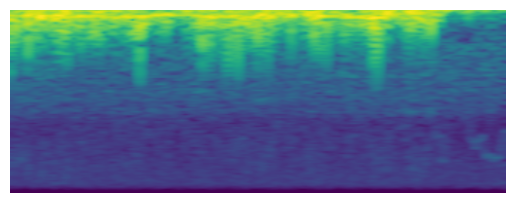

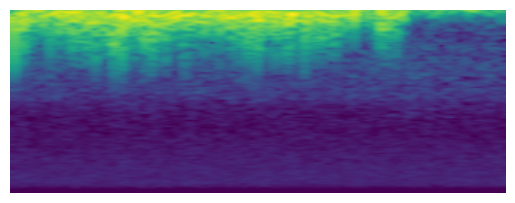

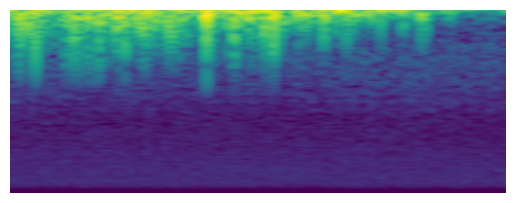

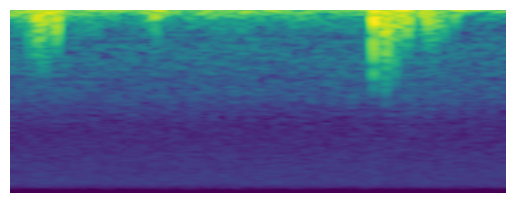

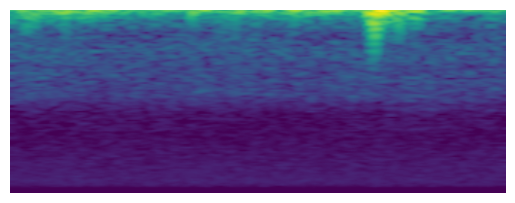

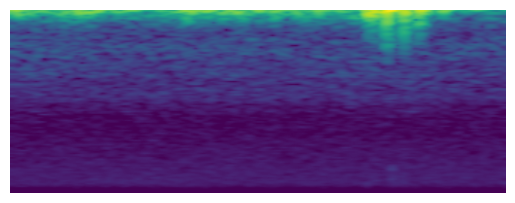

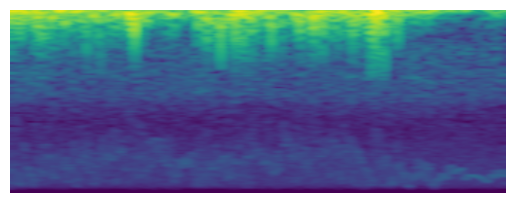

In [10]:
for images, spectrograms, labels in train_dataloader:
    # Your training loop here
    image_0 = images[0]
    image_1 = images[1]
    image_2 = images[2]
    image_3 = images[3]
    image_4 = images[4]

    spec_0 = spectrograms[0]
    spec_1 = spectrograms[1]
    spec_2 = spectrograms[2]
    spec_3 = spectrograms[3]
    spec_4 = spectrograms[4]
    spec_5 = spectrograms[5]
    spec_6 = spectrograms[6]

    visualize_tensor(image_0)
    visualize_tensor(image_1)
    visualize_tensor(image_2)
    visualize_tensor(image_3)
    visualize_tensor(image_4)

    visualize_tensor(spec_0)
    visualize_tensor(spec_1)
    visualize_tensor(spec_2)
    visualize_tensor(spec_3)
    visualize_tensor(spec_4)
    visualize_tensor(spec_5)
    visualize_tensor(spec_6)
    break

In [11]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, output_features):
        super(ImageFeatureExtractor, self).__init__()
        resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the last layer

        # Freeze the parameters in the feature extraction layers
        for param in self.features.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(resnet50.fc.in_features, output_features)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class AudioFeatureExtractor(nn.Module):
    def __init__(self, output_features):
        super(AudioFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 23 * 64, output_features)  # Adjust the size based on your input dimensions

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self, image_output_features, audio_output_features, num_classes):
        super(CombinedModel, self).__init__()
        self.image_extractor = ImageFeatureExtractor(image_output_features)
        self.audio_extractor = AudioFeatureExtractor(audio_output_features)

        # Combine features from both extractors
        total_features = image_output_features * 5 + audio_output_features * 7
        self.classifier = nn.Linear(total_features, num_classes)

    def forward(self, image_0, image_1, image_2, image_3, image_4,
        audio_0, audio_1, audio_2, audio_3, audio_4, audio_5, audio_6
    ):
        image_features_0 = self.image_extractor(image_0)
        image_features_1 = self.image_extractor(image_1)
        image_features_2 = self.image_extractor(image_2)
        image_features_3 = self.image_extractor(image_3)
        image_features_4 = self.image_extractor(image_4)

        audio_features_0 = self.audio_extractor(audio_0)
        audio_features_1 = self.audio_extractor(audio_1)
        audio_features_2 = self.audio_extractor(audio_2)
        audio_features_3 = self.audio_extractor(audio_3)
        audio_features_4 = self.audio_extractor(audio_4)
        audio_features_5 = self.audio_extractor(audio_5)
        audio_features_6 = self.audio_extractor(audio_6)
        
        combined_features = torch.cat((
            image_features_0, image_features_1, image_features_2, image_features_3, image_features_4,
            audio_features_0, audio_features_1, audio_features_2, audio_features_3, audio_features_4,
            audio_features_5, audio_features_6
        ), dim=1)
        output = self.classifier(combined_features)
        return output

In [12]:
image_output_features = 512 # Adjust as needed
audio_output_features = 256  # Adjust as needed
num_classes = 2  # Adjust based on your dataset

model = CombinedModel(image_output_features, audio_output_features, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted
criterion = nn.CrossEntropyLoss()

In [13]:
num_epochs = 20  # Number of epochs can be adjusted
train_metrics = []
val_metrics = []
best_score = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_running_loss = 0.0
    train_TP = 0
    train_FP = 0
    train_FN = 0
    train_TN = 0

    loop = tqdm(train_dataloader, leave=True)
    for i, (images, spectrograms, labels) in enumerate(loop):     
        # Zero the parameter gradients
        optimizer.zero_grad()

        image_0 = images[0].to(device)
        image_1 = images[1].to(device)
        image_2 = images[2].to(device)
        image_3 = images[3].to(device)
        image_4 = images[4].to(device)

        spec_0 = spectrograms[0].to(device)
        spec_1 = spectrograms[1].to(device)
        spec_2 = spectrograms[2].to(device)
        spec_3 = spectrograms[3].to(device)
        spec_4 = spectrograms[4].to(device)
        spec_5 = spectrograms[5].to(device)
        spec_6 = spectrograms[6].to(device)

        # Forward pass
        outputs = model(
            image_0, image_1, image_2, image_3, image_4,
            spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
        )

        # Convert labels and predictions to boolean values if they're not already
        labels_bool = labels.bool()
        outputs = outputs.cpu()
        _, predicted_classes = torch.max(outputs, 1)

        train_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
        train_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
        train_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
        train_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()

        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        train_running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            accuracy = (train_TP + train_TN) / (train_TP + train_FP + train_FN + train_TN)
            recall = train_TP / (train_TP + train_FN) if (train_TP + train_FN) > 0 else 0
            iou = train_TP / (train_TP + train_FP + train_FN) if (train_TP + train_FP + train_FN) > 0 else 0
            
            print(f"[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {train_running_loss / 10:.4f}, "
                  f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
            
            metric = {
                "loss": train_running_loss / 10,
                "accuracy": accuracy,
                "recall": recall,
                "iou": iou,
                "TP": train_TP,
                "FP": train_FP,
                "TN": train_TN,
                "FN": train_FN,
            }

            train_metrics.append(metric)

            train_running_loss = 0.0
            train_TP = 0
            train_FP = 0
            train_FN = 0
            train_TN = 0

            with open(f'{MODEL_DIR}/training_metrics.json', 'w') as f:
                json.dump(train_metrics, f, indent=4)
    
    with torch.no_grad():
        model.eval()  # Set the model to training mode
        val_loss = 0.0
        val_TP = 0
        val_FP = 0
        val_FN = 0
        val_TN = 0

        loop = tqdm(val_dataloader, leave=True)
        k = 0
        for i, (images, spectrograms, labels) in enumerate(loop):     
            image_0 = images[0].to(device)
            image_1 = images[1].to(device)
            image_2 = images[2].to(device)
            image_3 = images[3].to(device)
            image_4 = images[4].to(device)

            spec_0 = spectrograms[0].to(device)
            spec_1 = spectrograms[1].to(device)
            spec_2 = spectrograms[2].to(device)
            spec_3 = spectrograms[3].to(device)
            spec_4 = spectrograms[4].to(device)
            spec_5 = spectrograms[5].to(device)
            spec_6 = spectrograms[6].to(device)

            # Forward pass
            outputs = model(
                image_0, image_1, image_2, image_3, image_4,
                spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
            )

            outputs = outputs.cpu()

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            k += 1

            # Convert labels and predictions to boolean values if they're not already
            labels_bool = labels.bool()
            outputs = outputs.cpu()
            _, predicted_classes = torch.max(outputs, 1)

            val_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
            val_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
            val_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
            val_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()
        
        accuracy = (val_TP + val_TN) / (val_TP + val_FP + val_FN + val_TN)
        recall = val_TP / (val_TP + val_FN) if (val_TP + val_FN) > 0 else 0
        iou = val_TP / (val_TP + val_FP + val_FN) if (val_TP + val_FP + val_FN) > 0 else 0
        val_loss = val_loss / k

        metric = {
            "loss": val_loss,
            "accuracy": accuracy,
            "recall": recall,
            "iou": iou,
            "TP": val_TP,
            "FP": val_FP,
            "TN": val_TN,
            "FN": val_FN,
        }

        val_metrics.append(metric)

        with open(f'{MODEL_DIR}/val_metrics.json', 'w') as f:
            json.dump(val_metrics, f, indent=4)

        if (iou > best_score):
            best_score = iou
            torch.save(model, f'{MODEL_DIR}/best_model_epoch_{epoch + 1}.pth')

        print(f"[Val Epoch: {epoch + 1}] Loss: {val_loss:.4f}, "
                  f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

print("Finished Training")

  0%|          | 0/231 [00:00<?, ?it/s]

  4%|▍         | 10/231 [01:24<30:10,  8.19s/it]

[Epoch: 1, Batch: 10] Loss: 2.9659, Accuracy: 0.5344, Recall: 0.2140, IoU: 0.1558


  9%|▊         | 20/231 [02:43<27:03,  7.69s/it]

[Epoch: 1, Batch: 20] Loss: 0.7105, Accuracy: 0.6219, Recall: 0.6141, IoU: 0.3795


 13%|█▎        | 30/231 [04:07<27:22,  8.17s/it]

[Epoch: 1, Batch: 30] Loss: 0.4797, Accuracy: 0.7641, Recall: 0.7273, IoU: 0.5382


 17%|█▋        | 40/231 [05:29<24:35,  7.72s/it]

[Epoch: 1, Batch: 40] Loss: 0.4230, Accuracy: 0.8016, Recall: 0.6385, IoU: 0.5171


 22%|██▏       | 50/231 [06:44<22:02,  7.31s/it]

[Epoch: 1, Batch: 50] Loss: 0.3561, Accuracy: 0.8297, Recall: 0.6967, IoU: 0.6093


 26%|██▌       | 60/231 [07:59<21:00,  7.37s/it]

[Epoch: 1, Batch: 60] Loss: 0.3132, Accuracy: 0.8766, Recall: 0.7436, IoU: 0.6877


 30%|███       | 70/231 [09:11<19:04,  7.11s/it]

[Epoch: 1, Batch: 70] Loss: 0.3277, Accuracy: 0.8547, Recall: 0.7435, IoU: 0.6477


 35%|███▍      | 80/231 [10:24<17:45,  7.05s/it]

[Epoch: 1, Batch: 80] Loss: 0.2987, Accuracy: 0.8656, Recall: 0.8043, IoU: 0.6873


 39%|███▉      | 90/231 [11:36<16:47,  7.14s/it]

[Epoch: 1, Batch: 90] Loss: 0.2770, Accuracy: 0.8875, Recall: 0.8269, IoU: 0.7491


 43%|████▎     | 100/231 [12:48<15:18,  7.01s/it]

[Epoch: 1, Batch: 100] Loss: 0.2262, Accuracy: 0.9016, Recall: 0.8250, IoU: 0.7586


 48%|████▊     | 110/231 [13:58<13:47,  6.84s/it]

[Epoch: 1, Batch: 110] Loss: 0.1989, Accuracy: 0.9203, Recall: 0.8445, IoU: 0.7976


 52%|█████▏    | 120/231 [15:08<12:50,  6.95s/it]

[Epoch: 1, Batch: 120] Loss: 0.2016, Accuracy: 0.9187, Recall: 0.8669, IoU: 0.8052


 56%|█████▋    | 130/231 [16:17<11:31,  6.85s/it]

[Epoch: 1, Batch: 130] Loss: 0.2152, Accuracy: 0.9203, Recall: 0.8590, IoU: 0.7976


 61%|██████    | 140/231 [17:25<10:09,  6.70s/it]

[Epoch: 1, Batch: 140] Loss: 0.1840, Accuracy: 0.9234, Recall: 0.8705, IoU: 0.7992


 65%|██████▍   | 150/231 [18:35<09:40,  7.17s/it]

[Epoch: 1, Batch: 150] Loss: 0.1998, Accuracy: 0.9187, Recall: 0.8609, IoU: 0.7920


 69%|██████▉   | 160/231 [19:47<08:10,  6.92s/it]

[Epoch: 1, Batch: 160] Loss: 0.2297, Accuracy: 0.9156, Recall: 0.8601, IoU: 0.7947


 74%|███████▎  | 170/231 [20:56<06:57,  6.85s/it]

[Epoch: 1, Batch: 170] Loss: 0.1885, Accuracy: 0.9219, Recall: 0.8643, IoU: 0.7925


 78%|███████▊  | 180/231 [22:04<05:44,  6.75s/it]

[Epoch: 1, Batch: 180] Loss: 0.1789, Accuracy: 0.9141, Recall: 0.8547, IoU: 0.7843


 82%|████████▏ | 190/231 [23:12<04:31,  6.63s/it]

[Epoch: 1, Batch: 190] Loss: 0.1761, Accuracy: 0.9328, Recall: 0.8991, IoU: 0.8201


 87%|████████▋ | 200/231 [24:20<03:23,  6.55s/it]

[Epoch: 1, Batch: 200] Loss: 0.1616, Accuracy: 0.9375, Recall: 0.8852, IoU: 0.8438


 91%|█████████ | 210/231 [25:28<02:20,  6.68s/it]

[Epoch: 1, Batch: 210] Loss: 0.1578, Accuracy: 0.9375, Recall: 0.8958, IoU: 0.8431


 95%|█████████▌| 220/231 [26:35<01:12,  6.58s/it]

[Epoch: 1, Batch: 220] Loss: 0.1911, Accuracy: 0.9281, Recall: 0.8996, IoU: 0.8351


100%|█████████▉| 230/231 [27:43<00:06,  6.74s/it]

[Epoch: 1, Batch: 230] Loss: 0.2067, Accuracy: 0.9172, Recall: 0.8924, IoU: 0.8087


100%|██████████| 66/66 [07:17<00:00,  6.63s/it]


[Val Epoch: 1] Loss: 0.2683, Accuracy: 0.8983, Recall: 0.7250, IoU: 0.7227


  4%|▍         | 10/231 [00:50<18:23,  4.99s/it]

[Epoch: 2, Batch: 10] Loss: 0.1539, Accuracy: 0.9437, Recall: 0.8996, IoU: 0.8566


  9%|▊         | 20/231 [01:40<17:24,  4.95s/it]

[Epoch: 2, Batch: 20] Loss: 0.1723, Accuracy: 0.9297, Recall: 0.8717, IoU: 0.8140


 13%|█▎        | 30/231 [02:30<16:43,  4.99s/it]

[Epoch: 2, Batch: 30] Loss: 0.1975, Accuracy: 0.9266, Recall: 0.8692, IoU: 0.8142


 17%|█▋        | 40/231 [03:20<15:49,  4.97s/it]

[Epoch: 2, Batch: 40] Loss: 0.1920, Accuracy: 0.9281, Recall: 0.8650, IoU: 0.8167


 22%|██▏       | 50/231 [04:11<14:59,  4.97s/it]

[Epoch: 2, Batch: 50] Loss: 0.1790, Accuracy: 0.9203, Recall: 0.8939, IoU: 0.8223


 26%|██▌       | 60/231 [05:01<14:07,  4.95s/it]

[Epoch: 2, Batch: 60] Loss: 0.1746, Accuracy: 0.9375, Recall: 0.9069, IoU: 0.8485


 30%|███       | 70/231 [05:51<13:17,  4.95s/it]

[Epoch: 2, Batch: 70] Loss: 0.1622, Accuracy: 0.9297, Recall: 0.8947, IoU: 0.8308


 35%|███▍      | 80/231 [06:41<12:22,  4.92s/it]

[Epoch: 2, Batch: 80] Loss: 0.2272, Accuracy: 0.9109, Recall: 0.8426, IoU: 0.7615


 39%|███▉      | 90/231 [07:31<11:30,  4.90s/it]

[Epoch: 2, Batch: 90] Loss: 0.1490, Accuracy: 0.9344, Recall: 0.8821, IoU: 0.8279


 43%|████▎     | 100/231 [08:21<10:48,  4.95s/it]

[Epoch: 2, Batch: 100] Loss: 0.1473, Accuracy: 0.9406, Recall: 0.9087, IoU: 0.8628


 48%|████▊     | 110/231 [09:11<09:53,  4.91s/it]

[Epoch: 2, Batch: 110] Loss: 0.1857, Accuracy: 0.9203, Recall: 0.8958, IoU: 0.8083


 52%|█████▏    | 120/231 [10:01<09:05,  4.91s/it]

[Epoch: 2, Batch: 120] Loss: 0.2256, Accuracy: 0.9078, Recall: 0.8426, IoU: 0.7552


 56%|█████▋    | 130/231 [10:51<08:19,  4.95s/it]

[Epoch: 2, Batch: 130] Loss: 0.1524, Accuracy: 0.9406, Recall: 0.8824, IoU: 0.8555


 61%|██████    | 140/231 [11:41<07:25,  4.90s/it]

[Epoch: 2, Batch: 140] Loss: 0.1484, Accuracy: 0.9406, Recall: 0.9000, IoU: 0.8555


 65%|██████▍   | 150/231 [12:31<06:36,  4.90s/it]

[Epoch: 2, Batch: 150] Loss: 0.1719, Accuracy: 0.9281, Recall: 0.8657, IoU: 0.8026


 69%|██████▉   | 160/231 [13:22<05:55,  5.01s/it]

[Epoch: 2, Batch: 160] Loss: 0.1394, Accuracy: 0.9453, Recall: 0.8863, IoU: 0.8423


 74%|███████▎  | 170/231 [14:12<04:58,  4.90s/it]

[Epoch: 2, Batch: 170] Loss: 0.1440, Accuracy: 0.9422, Recall: 0.9227, IoU: 0.8532


 78%|███████▊  | 180/231 [15:03<04:13,  4.97s/it]

[Epoch: 2, Batch: 180] Loss: 0.1523, Accuracy: 0.9406, Recall: 0.9016, IoU: 0.8527


 82%|████████▏ | 190/231 [15:53<03:22,  4.93s/it]

[Epoch: 2, Batch: 190] Loss: 0.1556, Accuracy: 0.9422, Recall: 0.8913, IoU: 0.8471


 87%|████████▋ | 200/231 [16:43<02:33,  4.96s/it]

[Epoch: 2, Batch: 200] Loss: 0.1248, Accuracy: 0.9563, Recall: 0.9265, IoU: 0.8902


 91%|█████████ | 210/231 [17:33<01:43,  4.93s/it]

[Epoch: 2, Batch: 210] Loss: 0.1001, Accuracy: 0.9672, Recall: 0.9484, IoU: 0.9192


 95%|█████████▌| 220/231 [18:24<00:54,  4.95s/it]

[Epoch: 2, Batch: 220] Loss: 0.1507, Accuracy: 0.9375, Recall: 0.9237, IoU: 0.8582


100%|█████████▉| 230/231 [19:14<00:04,  4.97s/it]

[Epoch: 2, Batch: 230] Loss: 0.1580, Accuracy: 0.9406, Recall: 0.8924, IoU: 0.8397


100%|██████████| 66/66 [05:24<00:00,  4.92s/it]


[Val Epoch: 2] Loss: 0.1238, Accuracy: 0.9491, Recall: 0.8787, IoU: 0.8631


  4%|▍         | 10/231 [00:50<18:18,  4.97s/it]

[Epoch: 3, Batch: 10] Loss: 0.1083, Accuracy: 0.9672, Recall: 0.9412, IoU: 0.9143


  9%|▊         | 20/231 [01:40<17:17,  4.92s/it]

[Epoch: 3, Batch: 20] Loss: 0.1150, Accuracy: 0.9547, Recall: 0.9219, IoU: 0.8906


 13%|█▎        | 30/231 [02:30<16:26,  4.91s/it]

[Epoch: 3, Batch: 30] Loss: 0.1226, Accuracy: 0.9578, Recall: 0.9269, IoU: 0.8826


 17%|█▋        | 40/231 [03:20<15:45,  4.95s/it]

[Epoch: 3, Batch: 40] Loss: 0.1062, Accuracy: 0.9547, Recall: 0.9289, IoU: 0.8902


 22%|██▏       | 50/231 [04:11<14:50,  4.92s/it]

[Epoch: 3, Batch: 50] Loss: 0.1432, Accuracy: 0.9437, Recall: 0.8861, IoU: 0.8537


 26%|██▌       | 60/231 [05:01<14:06,  4.95s/it]

[Epoch: 3, Batch: 60] Loss: 0.1189, Accuracy: 0.9531, Recall: 0.9258, IoU: 0.8760


 30%|███       | 70/231 [05:51<13:17,  4.96s/it]

[Epoch: 3, Batch: 70] Loss: 0.1120, Accuracy: 0.9516, Recall: 0.9145, IoU: 0.8735


 35%|███▍      | 80/231 [06:41<12:21,  4.91s/it]

[Epoch: 3, Batch: 80] Loss: 0.1801, Accuracy: 0.9281, Recall: 0.8819, IoU: 0.8296


 39%|███▉      | 90/231 [07:31<11:34,  4.93s/it]

[Epoch: 3, Batch: 90] Loss: 0.1729, Accuracy: 0.9281, Recall: 0.9017, IoU: 0.8210


 43%|████▎     | 100/231 [08:22<10:54,  5.00s/it]

[Epoch: 3, Batch: 100] Loss: 0.1582, Accuracy: 0.9281, Recall: 0.8927, IoU: 0.8189


 48%|████▊     | 110/231 [09:12<10:02,  4.98s/it]

[Epoch: 3, Batch: 110] Loss: 0.1210, Accuracy: 0.9469, Recall: 0.9177, IoU: 0.8677


 52%|█████▏    | 120/231 [10:02<09:11,  4.97s/it]

[Epoch: 3, Batch: 120] Loss: 0.1477, Accuracy: 0.9375, Recall: 0.9134, IoU: 0.8529


 56%|█████▋    | 130/231 [10:52<08:19,  4.94s/it]

[Epoch: 3, Batch: 130] Loss: 0.1356, Accuracy: 0.9406, Recall: 0.9038, IoU: 0.8504


 61%|██████    | 140/231 [11:43<07:34,  4.99s/it]

[Epoch: 3, Batch: 140] Loss: 0.1256, Accuracy: 0.9531, Recall: 0.9167, IoU: 0.8800


 65%|██████▍   | 150/231 [12:33<06:42,  4.97s/it]

[Epoch: 3, Batch: 150] Loss: 0.1146, Accuracy: 0.9516, Recall: 0.9167, IoU: 0.8708


 69%|██████▉   | 160/231 [13:24<05:55,  5.01s/it]

[Epoch: 3, Batch: 160] Loss: 0.1366, Accuracy: 0.9437, Recall: 0.9283, IoU: 0.8594


 74%|███████▎  | 170/231 [14:14<05:01,  4.94s/it]

[Epoch: 3, Batch: 170] Loss: 0.1367, Accuracy: 0.9469, Recall: 0.9052, IoU: 0.8607


 78%|███████▊  | 180/231 [15:04<04:16,  5.03s/it]

[Epoch: 3, Batch: 180] Loss: 0.1212, Accuracy: 0.9516, Recall: 0.9256, IoU: 0.8784


 82%|████████▏ | 190/231 [15:54<03:23,  4.96s/it]

[Epoch: 3, Batch: 190] Loss: 0.1285, Accuracy: 0.9547, Recall: 0.9463, IoU: 0.8876


 87%|████████▋ | 200/231 [16:45<02:35,  5.00s/it]

[Epoch: 3, Batch: 200] Loss: 0.1209, Accuracy: 0.9500, Recall: 0.8912, IoU: 0.8694


 91%|█████████ | 210/231 [17:35<01:44,  4.96s/it]

[Epoch: 3, Batch: 210] Loss: 0.1231, Accuracy: 0.9484, Recall: 0.9195, IoU: 0.8680


 95%|█████████▌| 220/231 [18:25<00:54,  4.97s/it]

[Epoch: 3, Batch: 220] Loss: 0.1311, Accuracy: 0.9484, Recall: 0.9188, IoU: 0.8669


100%|█████████▉| 230/231 [19:16<00:04,  4.98s/it]

[Epoch: 3, Batch: 230] Loss: 0.1649, Accuracy: 0.9469, Recall: 0.8927, IoU: 0.8595


100%|██████████| 66/66 [05:27<00:00,  4.96s/it]


[Val Epoch: 3] Loss: 0.1060, Accuracy: 0.9573, Recall: 0.9196, IoU: 0.8874


  4%|▍         | 10/231 [00:50<18:15,  4.96s/it]

[Epoch: 4, Batch: 10] Loss: 0.1327, Accuracy: 0.9484, Recall: 0.9167, IoU: 0.8696


  9%|▊         | 20/231 [01:40<17:25,  4.96s/it]

[Epoch: 4, Batch: 20] Loss: 0.1060, Accuracy: 0.9516, Recall: 0.9060, IoU: 0.8724


 13%|█▎        | 30/231 [02:30<16:43,  4.99s/it]

[Epoch: 4, Batch: 30] Loss: 0.1439, Accuracy: 0.9437, Recall: 0.9228, IoU: 0.8631


 17%|█▋        | 40/231 [03:21<15:48,  4.97s/it]

[Epoch: 4, Batch: 40] Loss: 0.1218, Accuracy: 0.9578, Recall: 0.9095, IoU: 0.8816


 22%|██▏       | 50/231 [04:11<14:55,  4.95s/it]

[Epoch: 4, Batch: 50] Loss: 0.1099, Accuracy: 0.9563, Recall: 0.9295, IoU: 0.8889


 26%|██▌       | 60/231 [05:01<14:09,  4.97s/it]

[Epoch: 4, Batch: 60] Loss: 0.1077, Accuracy: 0.9563, Recall: 0.9207, IoU: 0.8819


 30%|███       | 70/231 [05:52<13:14,  4.93s/it]

[Epoch: 4, Batch: 70] Loss: 0.0780, Accuracy: 0.9750, Recall: 0.9680, IoU: 0.9380


 35%|███▍      | 80/231 [06:42<12:27,  4.95s/it]

[Epoch: 4, Batch: 80] Loss: 0.0917, Accuracy: 0.9609, Recall: 0.9425, IoU: 0.8950


 39%|███▉      | 90/231 [07:32<11:38,  4.96s/it]

[Epoch: 4, Batch: 90] Loss: 0.1417, Accuracy: 0.9500, Recall: 0.9094, IoU: 0.8783


 43%|████▎     | 100/231 [08:23<10:51,  4.98s/it]

[Epoch: 4, Batch: 100] Loss: 0.0961, Accuracy: 0.9563, Recall: 0.9247, IoU: 0.8876


 48%|████▊     | 110/231 [09:14<10:14,  5.08s/it]

[Epoch: 4, Batch: 110] Loss: 0.1148, Accuracy: 0.9516, Recall: 0.9267, IoU: 0.8740


 52%|█████▏    | 120/231 [10:04<09:10,  4.96s/it]

[Epoch: 4, Batch: 120] Loss: 0.1101, Accuracy: 0.9594, Recall: 0.9267, IoU: 0.8921


 56%|█████▋    | 130/231 [10:54<08:17,  4.93s/it]

[Epoch: 4, Batch: 130] Loss: 0.0829, Accuracy: 0.9703, Recall: 0.9353, IoU: 0.9195


 61%|██████    | 140/231 [11:44<07:26,  4.91s/it]

[Epoch: 4, Batch: 140] Loss: 0.0897, Accuracy: 0.9672, Recall: 0.9506, IoU: 0.9167


 65%|██████▍   | 150/231 [12:35<06:37,  4.91s/it]

[Epoch: 4, Batch: 150] Loss: 0.0903, Accuracy: 0.9688, Recall: 0.9386, IoU: 0.9145


 69%|██████▉   | 160/231 [13:25<05:52,  4.96s/it]

[Epoch: 4, Batch: 160] Loss: 0.0849, Accuracy: 0.9641, Recall: 0.9424, IoU: 0.9087


 74%|███████▎  | 170/231 [14:15<05:01,  4.94s/it]

[Epoch: 4, Batch: 170] Loss: 0.1226, Accuracy: 0.9547, Recall: 0.9513, IoU: 0.8811


 78%|███████▊  | 180/231 [15:05<04:15,  5.00s/it]

[Epoch: 4, Batch: 180] Loss: 0.0999, Accuracy: 0.9578, Recall: 0.9344, IoU: 0.8941


 82%|████████▏ | 190/231 [15:56<03:23,  4.96s/it]

[Epoch: 4, Batch: 190] Loss: 0.0976, Accuracy: 0.9641, Recall: 0.9447, IoU: 0.9061


 87%|████████▋ | 200/231 [16:46<02:32,  4.91s/it]

[Epoch: 4, Batch: 200] Loss: 0.1014, Accuracy: 0.9578, Recall: 0.9424, IoU: 0.8945


 91%|█████████ | 210/231 [17:36<01:45,  5.00s/it]

[Epoch: 4, Batch: 210] Loss: 0.1252, Accuracy: 0.9516, Recall: 0.9202, IoU: 0.8760


 95%|█████████▌| 220/231 [18:27<00:54,  4.96s/it]

[Epoch: 4, Batch: 220] Loss: 0.1027, Accuracy: 0.9547, Recall: 0.9222, IoU: 0.8910


100%|█████████▉| 230/231 [19:17<00:05,  5.00s/it]

[Epoch: 4, Batch: 230] Loss: 0.1018, Accuracy: 0.9594, Recall: 0.9400, IoU: 0.9004


100%|██████████| 66/66 [05:25<00:00,  4.93s/it]


[Val Epoch: 4] Loss: 0.0973, Accuracy: 0.9637, Recall: 0.9533, IoU: 0.9057


  4%|▍         | 10/231 [00:49<18:10,  4.93s/it]

[Epoch: 5, Batch: 10] Loss: 0.0830, Accuracy: 0.9641, Recall: 0.9472, IoU: 0.9161


  9%|▊         | 20/231 [01:40<17:24,  4.95s/it]

[Epoch: 5, Batch: 20] Loss: 0.0875, Accuracy: 0.9656, Recall: 0.9454, IoU: 0.9109


 13%|█▎        | 30/231 [02:30<16:34,  4.95s/it]

[Epoch: 5, Batch: 30] Loss: 0.0793, Accuracy: 0.9656, Recall: 0.9447, IoU: 0.9031


 17%|█▋        | 40/231 [03:20<15:47,  4.96s/it]

[Epoch: 5, Batch: 40] Loss: 0.0915, Accuracy: 0.9625, Recall: 0.9507, IoU: 0.8983


 22%|██▏       | 50/231 [04:11<15:03,  4.99s/it]

[Epoch: 5, Batch: 50] Loss: 0.0894, Accuracy: 0.9688, Recall: 0.9433, IoU: 0.9209


 26%|██▌       | 60/231 [05:01<14:04,  4.94s/it]

[Epoch: 5, Batch: 60] Loss: 0.0670, Accuracy: 0.9750, Recall: 0.9487, IoU: 0.9328


 30%|███       | 70/231 [05:51<13:17,  4.95s/it]

[Epoch: 5, Batch: 70] Loss: 0.1067, Accuracy: 0.9469, Recall: 0.9438, IoU: 0.8736


 35%|███▍      | 80/231 [06:41<12:27,  4.95s/it]

[Epoch: 5, Batch: 80] Loss: 0.1402, Accuracy: 0.9359, Recall: 0.9247, IoU: 0.8435


 39%|███▉      | 90/231 [07:31<11:34,  4.92s/it]

[Epoch: 5, Batch: 90] Loss: 0.1563, Accuracy: 0.9375, Recall: 0.8683, IoU: 0.8165


 43%|████▎     | 100/231 [08:21<10:48,  4.95s/it]

[Epoch: 5, Batch: 100] Loss: 0.0790, Accuracy: 0.9688, Recall: 0.9303, IoU: 0.9190


 48%|████▊     | 110/231 [09:11<09:59,  4.96s/it]

[Epoch: 5, Batch: 110] Loss: 0.0650, Accuracy: 0.9781, Recall: 0.9569, IoU: 0.9407


 52%|█████▏    | 120/231 [10:01<09:12,  4.98s/it]

[Epoch: 5, Batch: 120] Loss: 0.0851, Accuracy: 0.9703, Recall: 0.9538, IoU: 0.9228


 56%|█████▋    | 130/231 [10:51<08:18,  4.93s/it]

[Epoch: 5, Batch: 130] Loss: 0.0500, Accuracy: 0.9844, Recall: 0.9762, IoU: 0.9609


 61%|██████    | 140/231 [11:42<07:30,  4.95s/it]

[Epoch: 5, Batch: 140] Loss: 0.1044, Accuracy: 0.9688, Recall: 0.9454, IoU: 0.9184


 65%|██████▍   | 150/231 [12:32<06:42,  4.97s/it]

[Epoch: 5, Batch: 150] Loss: 0.1285, Accuracy: 0.9516, Recall: 0.9304, IoU: 0.8735


 69%|██████▉   | 160/231 [13:22<05:57,  5.04s/it]

[Epoch: 5, Batch: 160] Loss: 0.0706, Accuracy: 0.9766, Recall: 0.9496, IoU: 0.9378


 74%|███████▎  | 170/231 [14:12<05:02,  4.97s/it]

[Epoch: 5, Batch: 170] Loss: 0.0844, Accuracy: 0.9609, Recall: 0.9480, IoU: 0.9046


 78%|███████▊  | 180/231 [15:03<04:14,  4.99s/it]

[Epoch: 5, Batch: 180] Loss: 0.1204, Accuracy: 0.9563, Recall: 0.9395, IoU: 0.8927


 82%|████████▏ | 190/231 [15:53<03:24,  4.99s/it]

[Epoch: 5, Batch: 190] Loss: 0.0728, Accuracy: 0.9719, Recall: 0.9710, IoU: 0.9286


 87%|████████▋ | 200/231 [16:44<02:35,  5.01s/it]

[Epoch: 5, Batch: 200] Loss: 0.0686, Accuracy: 0.9672, Recall: 0.9526, IoU: 0.9198


 91%|█████████ | 210/231 [17:34<01:43,  4.94s/it]

[Epoch: 5, Batch: 210] Loss: 0.1158, Accuracy: 0.9547, Recall: 0.9244, IoU: 0.8776


 95%|█████████▌| 220/231 [18:24<00:54,  4.99s/it]

[Epoch: 5, Batch: 220] Loss: 0.1010, Accuracy: 0.9641, Recall: 0.9315, IoU: 0.8987


100%|█████████▉| 230/231 [19:15<00:04,  4.95s/it]

[Epoch: 5, Batch: 230] Loss: 0.1453, Accuracy: 0.9547, Recall: 0.9325, IoU: 0.8902


100%|██████████| 66/66 [05:24<00:00,  4.92s/it]


[Val Epoch: 5] Loss: 0.1057, Accuracy: 0.9600, Recall: 0.9293, IoU: 0.8945


  4%|▍         | 10/231 [00:50<18:12,  4.94s/it]

[Epoch: 6, Batch: 10] Loss: 0.0840, Accuracy: 0.9688, Recall: 0.9609, IoU: 0.9248


  9%|▊         | 20/231 [01:40<17:30,  4.98s/it]

[Epoch: 6, Batch: 20] Loss: 0.0946, Accuracy: 0.9672, Recall: 0.9662, IoU: 0.9160


 13%|█▎        | 30/231 [02:30<16:44,  5.00s/it]

[Epoch: 6, Batch: 30] Loss: 0.1291, Accuracy: 0.9391, Recall: 0.9211, IoU: 0.8627


 17%|█▋        | 40/231 [03:21<15:54,  5.00s/it]

[Epoch: 6, Batch: 40] Loss: 0.1212, Accuracy: 0.9500, Recall: 0.9244, IoU: 0.8667


 22%|██▏       | 50/231 [04:11<14:46,  4.90s/it]

[Epoch: 6, Batch: 50] Loss: 0.1247, Accuracy: 0.9594, Recall: 0.9271, IoU: 0.8980


 26%|██▌       | 60/231 [05:01<14:04,  4.94s/it]

[Epoch: 6, Batch: 60] Loss: 0.0758, Accuracy: 0.9703, Recall: 0.9518, IoU: 0.9258


 30%|███       | 70/231 [05:51<13:23,  4.99s/it]

[Epoch: 6, Batch: 70] Loss: 0.0860, Accuracy: 0.9641, Recall: 0.9336, IoU: 0.9017


 35%|███▍      | 80/231 [06:42<12:31,  4.97s/it]

[Epoch: 6, Batch: 80] Loss: 0.0682, Accuracy: 0.9734, Recall: 0.9695, IoU: 0.9373


 39%|███▉      | 90/231 [07:32<11:36,  4.94s/it]

[Epoch: 6, Batch: 90] Loss: 0.0658, Accuracy: 0.9719, Recall: 0.9459, IoU: 0.9211


 43%|████▎     | 100/231 [08:22<10:51,  4.97s/it]

[Epoch: 6, Batch: 100] Loss: 0.0674, Accuracy: 0.9766, Recall: 0.9607, IoU: 0.9362


 48%|████▊     | 110/231 [09:12<09:58,  4.95s/it]

[Epoch: 6, Batch: 110] Loss: 0.0555, Accuracy: 0.9812, Recall: 0.9636, IoU: 0.9520


 52%|█████▏    | 120/231 [10:03<09:10,  4.96s/it]

[Epoch: 6, Batch: 120] Loss: 0.0757, Accuracy: 0.9734, Recall: 0.9579, IoU: 0.9363


 56%|█████▋    | 130/231 [10:53<08:18,  4.94s/it]

[Epoch: 6, Batch: 130] Loss: 0.1406, Accuracy: 0.9484, Recall: 0.9177, IoU: 0.8653


 61%|██████    | 140/231 [11:43<07:28,  4.93s/it]

[Epoch: 6, Batch: 140] Loss: 0.1428, Accuracy: 0.9391, Recall: 0.9115, IoU: 0.8408


 65%|██████▍   | 150/231 [12:33<06:47,  5.03s/it]

[Epoch: 6, Batch: 150] Loss: 0.0962, Accuracy: 0.9609, Recall: 0.9457, IoU: 0.8932


 69%|██████▉   | 160/231 [13:24<05:52,  4.96s/it]

[Epoch: 6, Batch: 160] Loss: 0.1262, Accuracy: 0.9406, Recall: 0.9110, IoU: 0.8498


 74%|███████▎  | 170/231 [14:15<05:07,  5.04s/it]

[Epoch: 6, Batch: 170] Loss: 0.0930, Accuracy: 0.9609, Recall: 0.9327, IoU: 0.8927


 78%|███████▊  | 180/231 [15:06<04:16,  5.04s/it]

[Epoch: 6, Batch: 180] Loss: 0.0946, Accuracy: 0.9703, Recall: 0.9498, IoU: 0.9228


 82%|████████▏ | 190/231 [16:00<03:44,  5.48s/it]

[Epoch: 6, Batch: 190] Loss: 0.0817, Accuracy: 0.9672, Recall: 0.9439, IoU: 0.9058


 87%|████████▋ | 200/231 [16:51<02:36,  5.04s/it]

[Epoch: 6, Batch: 200] Loss: 0.0744, Accuracy: 0.9750, Recall: 0.9634, IoU: 0.9368


 91%|█████████ | 210/231 [17:41<01:43,  4.94s/it]

[Epoch: 6, Batch: 210] Loss: 0.1107, Accuracy: 0.9516, Recall: 0.9261, IoU: 0.8730


 95%|█████████▌| 220/231 [18:31<00:54,  4.96s/it]

[Epoch: 6, Batch: 220] Loss: 0.1330, Accuracy: 0.9578, Recall: 0.9377, IoU: 0.8993


100%|█████████▉| 230/231 [19:21<00:04,  4.96s/it]

[Epoch: 6, Batch: 230] Loss: 0.0905, Accuracy: 0.9672, Recall: 0.9435, IoU: 0.9118


100%|██████████| 66/66 [05:28<00:00,  4.98s/it]


[Val Epoch: 6] Loss: 0.1043, Accuracy: 0.9609, Recall: 0.9436, IoU: 0.8981


  4%|▍         | 10/231 [00:50<18:10,  4.94s/it]

[Epoch: 7, Batch: 10] Loss: 0.0719, Accuracy: 0.9703, Recall: 0.9593, IoU: 0.9255


  9%|▊         | 20/231 [01:40<17:30,  4.98s/it]

[Epoch: 7, Batch: 20] Loss: 0.0540, Accuracy: 0.9797, Recall: 0.9604, IoU: 0.9437


 13%|█▎        | 30/231 [02:31<16:52,  5.04s/it]

[Epoch: 7, Batch: 30] Loss: 0.0659, Accuracy: 0.9688, Recall: 0.9409, IoU: 0.9119


 17%|█▋        | 40/231 [03:23<15:55,  5.00s/it]

[Epoch: 7, Batch: 40] Loss: 0.0701, Accuracy: 0.9750, Recall: 0.9532, IoU: 0.9333


 22%|██▏       | 50/231 [04:14<15:14,  5.06s/it]

[Epoch: 7, Batch: 50] Loss: 0.1230, Accuracy: 0.9563, Recall: 0.9360, IoU: 0.8931


 26%|██▌       | 60/231 [05:05<14:24,  5.05s/it]

[Epoch: 7, Batch: 60] Loss: 0.0632, Accuracy: 0.9781, Recall: 0.9676, IoU: 0.9447


 30%|███       | 70/231 [05:56<13:32,  5.05s/it]

[Epoch: 7, Batch: 70] Loss: 0.0872, Accuracy: 0.9719, Recall: 0.9693, IoU: 0.9247


 35%|███▍      | 80/231 [06:47<12:34,  5.00s/it]

[Epoch: 7, Batch: 80] Loss: 0.0957, Accuracy: 0.9641, Recall: 0.9385, IoU: 0.9087


 39%|███▉      | 90/231 [07:38<11:35,  4.94s/it]

[Epoch: 7, Batch: 90] Loss: 0.0678, Accuracy: 0.9688, Recall: 0.9636, IoU: 0.9225


 43%|████▎     | 100/231 [08:28<10:47,  4.95s/it]

[Epoch: 7, Batch: 100] Loss: 0.0428, Accuracy: 0.9859, Recall: 0.9836, IoU: 0.9639


 48%|████▊     | 110/231 [09:18<10:03,  4.99s/it]

[Epoch: 7, Batch: 110] Loss: 0.0582, Accuracy: 0.9844, Recall: 0.9667, IoU: 0.9587


 52%|█████▏    | 120/231 [10:08<09:04,  4.91s/it]

[Epoch: 7, Batch: 120] Loss: 0.0761, Accuracy: 0.9703, Recall: 0.9506, IoU: 0.9240


 56%|█████▋    | 130/231 [10:59<08:21,  4.97s/it]

[Epoch: 7, Batch: 130] Loss: 0.0866, Accuracy: 0.9672, Recall: 0.9488, IoU: 0.9198


 61%|██████    | 140/231 [11:49<07:29,  4.94s/it]

[Epoch: 7, Batch: 140] Loss: 0.0505, Accuracy: 0.9797, Recall: 0.9609, IoU: 0.9444


 65%|██████▍   | 150/231 [12:39<06:38,  4.92s/it]

[Epoch: 7, Batch: 150] Loss: 0.0622, Accuracy: 0.9797, Recall: 0.9660, IoU: 0.9458


 69%|██████▉   | 160/231 [13:29<05:50,  4.93s/it]

[Epoch: 7, Batch: 160] Loss: 0.0827, Accuracy: 0.9719, Recall: 0.9655, IoU: 0.9256


 74%|███████▎  | 170/231 [14:20<05:05,  5.01s/it]

[Epoch: 7, Batch: 170] Loss: 0.0600, Accuracy: 0.9781, Recall: 0.9796, IoU: 0.9449


 78%|███████▊  | 180/231 [15:11<04:14,  5.00s/it]

[Epoch: 7, Batch: 180] Loss: 0.0985, Accuracy: 0.9688, Recall: 0.9498, IoU: 0.9190


 82%|████████▏ | 190/231 [16:02<03:23,  4.97s/it]

[Epoch: 7, Batch: 190] Loss: 0.0891, Accuracy: 0.9641, Recall: 0.9562, IoU: 0.9125


 87%|████████▋ | 200/231 [16:53<02:33,  4.96s/it]

[Epoch: 7, Batch: 200] Loss: 0.1395, Accuracy: 0.9359, Recall: 0.9143, IoU: 0.8453


 91%|█████████ | 210/231 [17:47<01:54,  5.44s/it]

[Epoch: 7, Batch: 210] Loss: 0.1527, Accuracy: 0.9453, Recall: 0.9130, IoU: 0.8571


 95%|█████████▌| 220/231 [18:41<01:00,  5.47s/it]

[Epoch: 7, Batch: 220] Loss: 0.0888, Accuracy: 0.9547, Recall: 0.9249, IoU: 0.8717


100%|█████████▉| 230/231 [19:32<00:04,  4.95s/it]

[Epoch: 7, Batch: 230] Loss: 0.1710, Accuracy: 0.9563, Recall: 0.9221, IoU: 0.8838


100%|██████████| 66/66 [05:58<00:00,  5.43s/it]


[Val Epoch: 7] Loss: 0.1777, Accuracy: 0.9431, Recall: 0.8638, IoU: 0.8473


  4%|▍         | 10/231 [00:54<19:59,  5.43s/it]

[Epoch: 8, Batch: 10] Loss: 0.0628, Accuracy: 0.9766, Recall: 0.9545, IoU: 0.9390


  5%|▌         | 12/231 [01:10<21:22,  5.86s/it]


KeyboardInterrupt: 

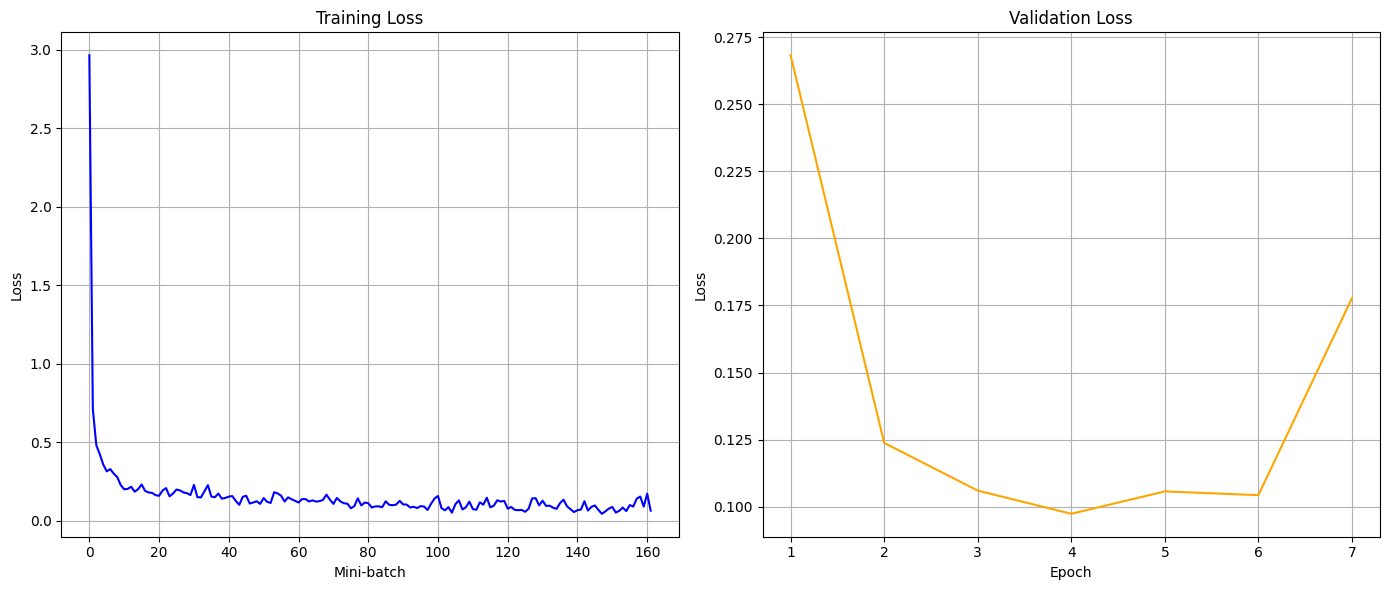

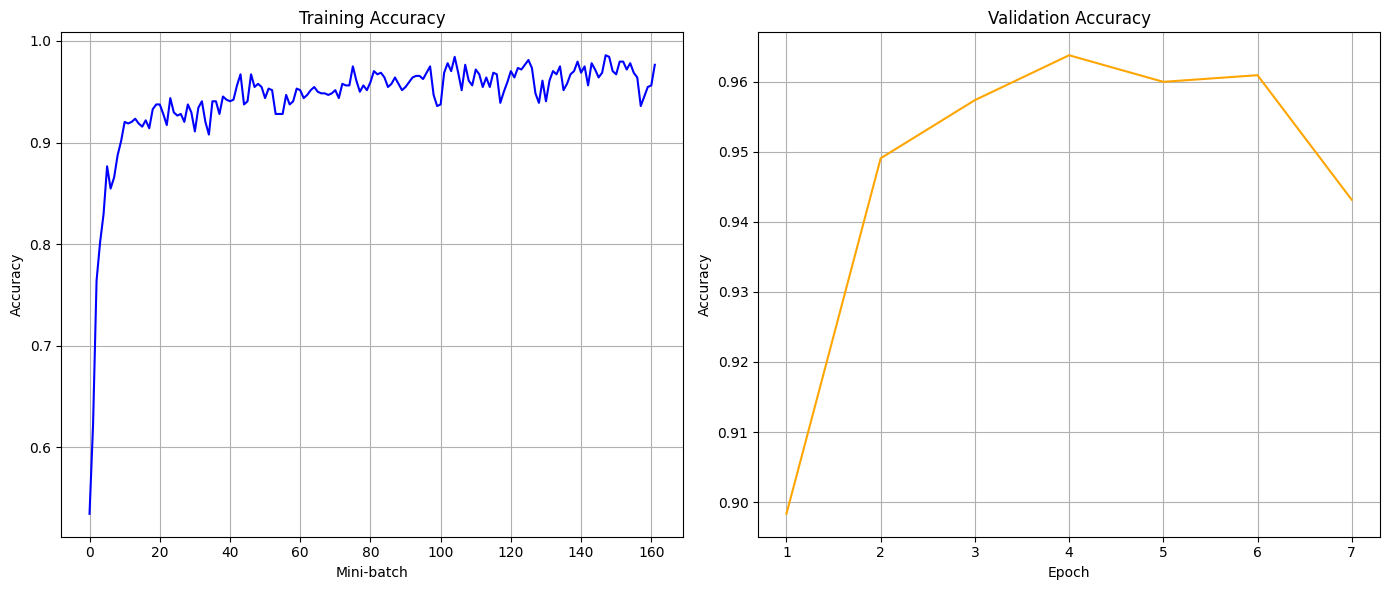

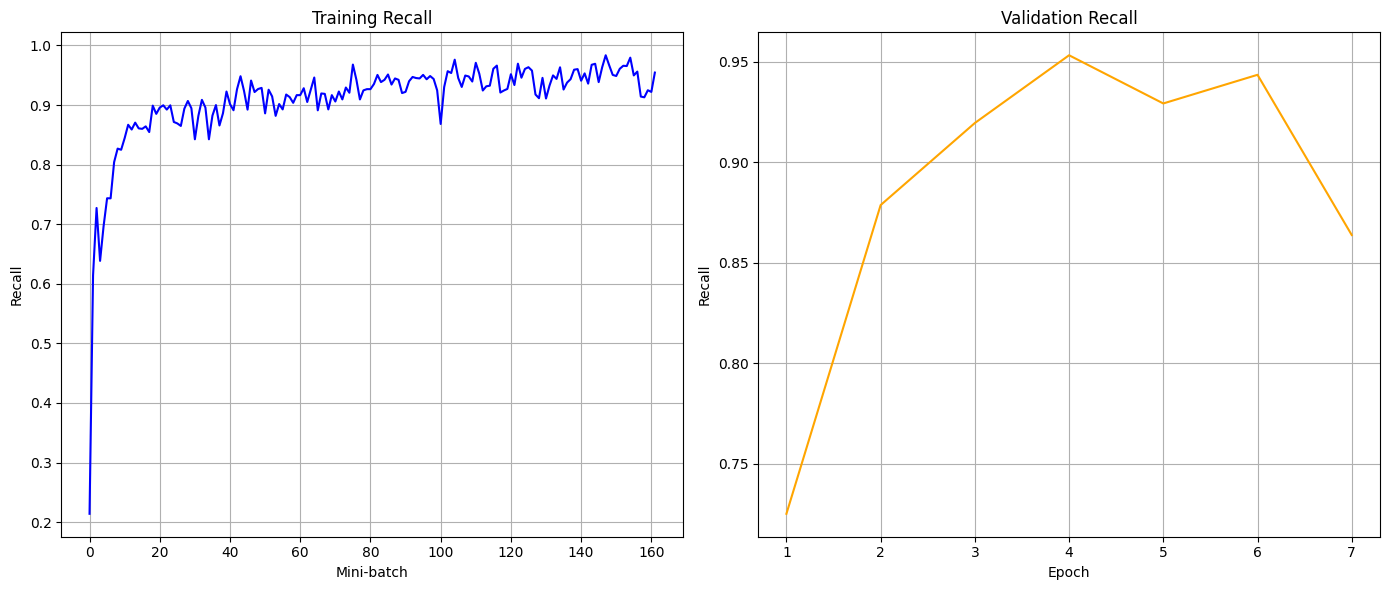

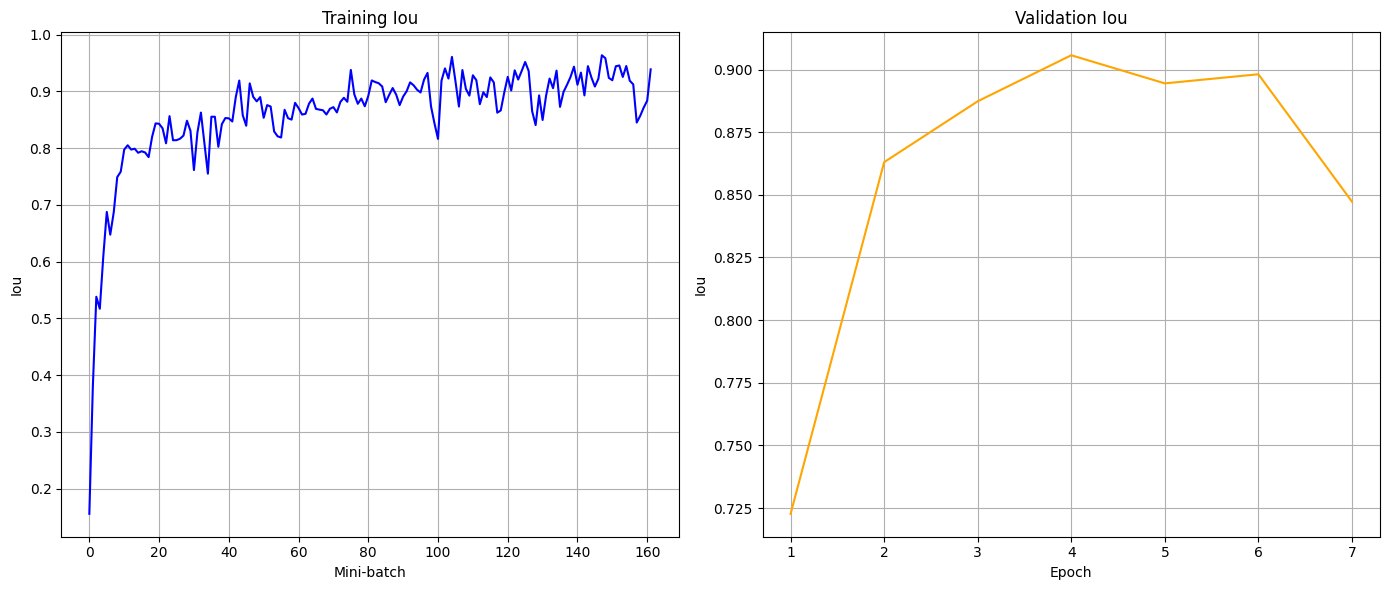

In [14]:
def plot_separate_metrics(train_metrics, val_metrics, metric_name):
    # Set up a larger plot
    plt.figure(figsize=(14, 6))

    # Subplot 1 for Training Metrics
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    train_values = [m[metric_name] for m in train_metrics]
    steps_train = list(range(len(train_values)))  # Assuming continuous recording
    plt.plot(steps_train, train_values, label='Train', color='blue')
    plt.xlabel('Mini-batch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Training {metric_name.capitalize()}')
    plt.grid(True)

    # Subplot 2 for Validation Metrics
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    val_values = [m[metric_name] for m in val_metrics]
    epochs_val = list(range(1, len(val_values) + 1))  # Assuming recording per epoch
    plt.plot(epochs_val, val_values, label='Validation', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Validation {metric_name.capitalize()}')
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

# Load validation metrics
with open(f'{MODEL_DIR}/val_metrics.json', 'r') as f:
    val_metrics = json.load(f)

# Load training metrics
with open(f'{MODEL_DIR}/training_metrics.json', 'r') as f:
    train_metrics = json.load(f)

plot_separate_metrics(train_metrics, val_metrics, 'loss')
plot_separate_metrics(train_metrics, val_metrics, 'accuracy')
plot_separate_metrics(train_metrics, val_metrics, 'recall')
plot_separate_metrics(train_metrics, val_metrics, 'iou')

In [15]:
model = torch.load(f'{MODEL_DIR}/best_model_epoch_4.pth').to(device)

with torch.no_grad():
    model.eval()  # Set the model to training mode
    test_TP = 0
    test_FP = 0
    test_FN = 0
    test_TN = 0

    loop = tqdm(test_dataloader, leave=True)
    k = 0
    for i, (images, spectrograms, labels) in enumerate(loop):     
        image_0 = images[0].to(device)
        image_1 = images[1].to(device)
        image_2 = images[2].to(device)
        image_3 = images[3].to(device)
        image_4 = images[4].to(device)

        spec_0 = spectrograms[0].to(device)
        spec_1 = spectrograms[1].to(device)
        spec_2 = spectrograms[2].to(device)
        spec_3 = spectrograms[3].to(device)
        spec_4 = spectrograms[4].to(device)
        spec_5 = spectrograms[5].to(device)
        spec_6 = spectrograms[6].to(device)

        # Forward pass
        outputs = model(
            image_0, image_1, image_2, image_3, image_4,
            spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
        )

        outputs = outputs.cpu()

        # Convert labels and predictions to boolean values if they're not already
        labels_bool = labels.bool()
        _, predicted_classes = torch.max(outputs, 1)

        test_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
        test_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
        test_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
        test_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()
    
    accuracy = (test_TP + test_TN) / (test_TP + test_FP + test_FN + test_TN)
    recall = test_TP / (test_TP + test_FN) if (test_TP + test_FN) > 0 else 0
    iou = test_TP / (test_TP + test_FP + test_FN) if (test_TP + test_FP + test_FN) > 0 else 0

    metric = {
        "accuracy": accuracy,
        "recall": recall,
        "iou": iou,
        "TP": test_TP,
        "FP": test_FP,
        "TN": test_TN,
        "FN": test_FN,
    }

    with open(f'{MODEL_DIR}/test_metrics.json', 'w') as f:
        json.dump(metric, f, indent=4)

    print(f"[Test Results] Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
print("Test finished")

100%|██████████| 33/33 [04:09<00:00,  7.56s/it]

[Test Results] Accuracy: 0.9616, Recall: 0.9564, IoU: 0.9021
Test finished
